In [1]:
### Load libraries -------
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
import geopandas as gpd
from shapely.geometry import Point, Polygon
import numba
import math
from datetime import datetime
import numpy as np
import seaborn as sns
from dtaidistance import dtw, clustering
from dtaidistance import dtw_visualisation as dtwvis
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Pandas parameters
#pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)

In [2]:
### Define out paths ------

# check if out path exists, if it does not exists add the path
if not os.path.exists('/Users/hannahfrank/desktop/conflict_escalation_out'):
    os.makedirs('/Users/hannahfrank/desktop/conflict_escalation_out')

# add subfolders for the out path
out_paths = {
    "desciptive_plots_outcome": '/Users/hannahfrank/desktop/conflict_escalation_out/plots',
    "data": '/Users/hannahfrank/desktop/conflict_escalation_out/data',
    "eval": '/Users/hannahfrank/desktop/conflict_escalation_out/eval'

}

for key, val in out_paths.items():
    if not os.path.exists(val):
        os.makedirs(val)
        
out_paths["data"]

'/Users/hannahfrank/desktop/conflict_escalation_out/data'

In [3]:
### Load data -------
ucdp = pd.read_csv(os.path.join(out_paths["data"], 
                                "ucdp.csv"))
ucdp.head(3)

,year_month,country_id,best,high,low,year,country
0,1989-01,700,691,1122,684,1989,Afghanistan
1,1989-02,700,160,160,41,1989,Afghanistan
2,1989-03,700,1744,6045,516,1989,Afghanistan


In [4]:
### Import time series -----
ts_dict = open("ucdp_time_series.pkl", "rb")
ts_ucdp = pickle.load(ts_dict)
ts_ucdp['Afghanistan, 1997']

array([  69,  182,  243,  191, 1553,  605,  177,  210,  383,  425,   58,
         98])

In [5]:
### Load cost matrix --------
ds_df = pd.read_csv(os.path.join(out_paths["data"], 
                                 "ucdp_dtw_matrix.csv"), index_col = [0])
ds_df.loc[["Afghanistan, 2019"]]

,"Afghanistan, 1989","Afghanistan, 1990","Afghanistan, 1991","Afghanistan, 1992","Afghanistan, 1993","Afghanistan, 1994","Afghanistan, 1995","Afghanistan, 1996","Afghanistan, 1997","Afghanistan, 1998",...,"Yemen (North Yemen), 2010","Yemen (North Yemen), 2011","Yemen (North Yemen), 2012","Yemen (North Yemen), 2013","Yemen (North Yemen), 2014","Yemen (North Yemen), 2015","Yemen (North Yemen), 2016","Yemen (North Yemen), 2017","Yemen (North Yemen), 2018","Yemen (North Yemen), 2019"
"Afghanistan, 2019",5658.292145,8188.951764,8163.549596,5595.295345,7126.779778,6454.196774,6673.046456,7770.34877,6091.977676,5091.314172,...,8620.207596,8323.667401,7930.132281,8510.821641,8153.284737,6422.971509,7900.114746,8028.794928,7345.734068,8219.048668


In [6]:
### Get years -----
years = ucdp["year"].unique()
years 

array([1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
       2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [7]:
### Get years range -----
years_range = [val for val in years for _ in range(0, 12)]

In [8]:
### Get countries -----
countries = ucdp["country"].unique()
countries

array(['Afghanistan', 'Algeria', 'Angola', 'Australia', 'Bangladesh',
       'Bhutan', 'Burkina Faso', 'Burundi', 'Cambodia (Kampuchea)',
       'Cameroon', 'Central African Republic', 'Chad', 'China', 'Comoros',
       'Congo', 'DR Congo (Zaire)', 'Djibouti', 'Egypt', 'Eritrea',
       'Ethiopia', 'Guinea', 'Guinea-Bissau', 'India', 'Indonesia',
       'Iran', 'Iraq', 'Israel', 'Ivory Coast', 'Jordan', 'Kenya',
       'Kyrgyzstan', 'Laos', 'Lebanon', 'Lesotho', 'Liberia', 'Libya',
       'Malaysia', 'Mali', 'Mauritania', 'Morocco', 'Mozambique',
       'Myanmar (Burma)', 'Namibia', 'Nepal', 'Niger', 'Nigeria',
       'Pakistan', 'Papua New Guinea', 'Philippines', 'Qatar', 'Rwanda',
       'Saudi Arabia', 'Senegal', 'Sierra Leone', 'Solomon Islands',
       'Somalia', 'South Sudan', 'Sri Lanka', 'Sudan', 'Syria',
       'Tajikistan', 'Thailand', 'Tunisia', 'Turkey', 'Uganda',
       'United Arab Emirates', 'Uzbekistan', 'Yemen (North Yemen)'],
      dtype=object)

In [9]:
### Get dates -----
dd = ucdp["year_month"].unique()
dd

array(['1989-01', '1989-02', '1989-03', '1989-04', '1989-05', '1989-06',
       '1989-07', '1989-08', '1989-09', '1989-10', '1989-12', '1990-02',
       '1990-03', '1990-04', '1990-05', '1990-07', '1990-10', '1990-11',
       '1991-01', '1991-02', '1991-03', '1991-04', '1991-05', '1991-07',
       '1991-08', '1991-09', '1991-10', '1991-11', '1991-12', '1992-02',
       '1992-03', '1992-04', '1992-05', '1992-06', '1992-07', '1992-08',
       '1992-09', '1992-10', '1992-12', '1993-01', '1993-02', '1993-03',
       '1993-04', '1993-05', '1993-06', '1993-07', '1993-08', '1993-09',
       '1993-10', '1993-11', '1993-12', '1994-01', '1994-02', '1994-03',
       '1994-04', '1994-05', '1994-06', '1994-07', '1994-08', '1994-09',
       '1994-10', '1994-11', '1994-12', '1995-01', '1995-02', '1995-03',
       '1995-04', '1995-05', '1995-06', '1995-07', '1995-08', '1995-09',
       '1995-10', '1995-11', '1995-12', '1996-01', '1996-02', '1996-03',
       '1996-04', '1996-05', '1996-06', '1996-07', 

In [10]:
### Create needed data structure -----
df_complete = pd.DataFrame([])

for country in countries: 
    for year in years:
        df_country = ucdp.loc[(ucdp["country"]==country) & 
             (ucdp["year"]==year)]
    
        dtw_country = ds_df.loc[[f"{country}, {year}"]]
    
        dtw_country = dtw_country.reset_index()
    
        dtw_country[['country',
                     'year']] = dtw_country['index'].str.split(',',expand=True)
        
        dtw_country.drop("index", 
                         axis=1, 
                         inplace=True)
        
        dtw_country[['year']] = dtw_country[['year']].astype(int)
        
        df_country_dtw = pd.merge(df_country, 
                           dtw_country, 
                           how="right", 
                           on="year")
    
    
        df_complete = df_complete.append(df_country_dtw)

df_complete.drop("country_y", 
                 axis=1, 
                 inplace=True)
df_complete

,year_month,country_id,best,high,low,year,country_x,"Afghanistan, 1989","Afghanistan, 1990","Afghanistan, 1991",...,"Yemen (North Yemen), 2010","Yemen (North Yemen), 2011","Yemen (North Yemen), 2012","Yemen (North Yemen), 2013","Yemen (North Yemen), 2014","Yemen (North Yemen), 2015","Yemen (North Yemen), 2016","Yemen (North Yemen), 2017","Yemen (North Yemen), 2018","Yemen (North Yemen), 2019"
0,1989-01,700,691,1122,684,1989,Afghanistan,0.000000,1345.974740,1643.627087,...,2108.084676,1799.118673,1426.837762,1937.181200,1659.278156,1379.089917,1484.987542,1414.723648,1184.628212,1688.525984
1,1989-02,700,160,160,41,1989,Afghanistan,0.000000,1345.974740,1643.627087,...,2108.084676,1799.118673,1426.837762,1937.181200,1659.278156,1379.089917,1484.987542,1414.723648,1184.628212,1688.525984
2,1989-03,700,1744,6045,516,1989,Afghanistan,0.000000,1345.974740,1643.627087,...,2108.084676,1799.118673,1426.837762,1937.181200,1659.278156,1379.089917,1484.987542,1414.723648,1184.628212,1688.525984
3,1989-04,700,494,1359,63,1989,Afghanistan,0.000000,1345.974740,1643.627087,...,2108.084676,1799.118673,1426.837762,1937.181200,1659.278156,1379.089917,1484.987542,1414.723648,1184.628212,1688.525984
4,1989-05,700,436,1705,0,1989,Afghanistan,0.000000,1345.974740,1643.627087,...,2108.084676,1799.118673,1426.837762,1937.181200,1659.278156,1379.089917,1484.987542,1414.723648,1184.628212,1688.525984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2019-08,678,283,291,283,2019,Yemen (North Yemen),1688.525984,451.449886,234.548502,...,478.972859,234.819079,488.761701,351.301864,248.207574,1515.857513,359.382804,811.835574,806.035359,0.000000
8,2019-09,678,180,185,172,2019,Yemen (North Yemen),1688.525984,451.449886,234.548502,...,478.972859,234.819079,488.761701,351.301864,248.207574,1515.857513,359.382804,811.835574,806.035359,0.000000
9,2019-10,678,128,128,128,2019,Yemen (North Yemen),1688.525984,451.449886,234.548502,...,478.972859,234.819079,488.761701,351.301864,248.207574,1515.857513,359.382804,811.835574,806.035359,0.000000
10,2019-11,678,90,99,88,2019,Yemen (North Yemen),1688.525984,451.449886,234.548502,...,478.972859,234.819079,488.761701,351.301864,248.207574,1515.857513,359.382804,811.835574,806.035359,0.000000


In [11]:
### Save df_complete -----------
df_complete.to_csv(os.path.join(out_paths["data"], 
                            "df_complete.csv"), 
                             index=True, 
                             sep=',')
df_complete

,year_month,country_id,best,high,low,year,country_x,"Afghanistan, 1989","Afghanistan, 1990","Afghanistan, 1991",...,"Yemen (North Yemen), 2010","Yemen (North Yemen), 2011","Yemen (North Yemen), 2012","Yemen (North Yemen), 2013","Yemen (North Yemen), 2014","Yemen (North Yemen), 2015","Yemen (North Yemen), 2016","Yemen (North Yemen), 2017","Yemen (North Yemen), 2018","Yemen (North Yemen), 2019"
0,1989-01,700,691,1122,684,1989,Afghanistan,0.000000,1345.974740,1643.627087,...,2108.084676,1799.118673,1426.837762,1937.181200,1659.278156,1379.089917,1484.987542,1414.723648,1184.628212,1688.525984
1,1989-02,700,160,160,41,1989,Afghanistan,0.000000,1345.974740,1643.627087,...,2108.084676,1799.118673,1426.837762,1937.181200,1659.278156,1379.089917,1484.987542,1414.723648,1184.628212,1688.525984
2,1989-03,700,1744,6045,516,1989,Afghanistan,0.000000,1345.974740,1643.627087,...,2108.084676,1799.118673,1426.837762,1937.181200,1659.278156,1379.089917,1484.987542,1414.723648,1184.628212,1688.525984
3,1989-04,700,494,1359,63,1989,Afghanistan,0.000000,1345.974740,1643.627087,...,2108.084676,1799.118673,1426.837762,1937.181200,1659.278156,1379.089917,1484.987542,1414.723648,1184.628212,1688.525984
4,1989-05,700,436,1705,0,1989,Afghanistan,0.000000,1345.974740,1643.627087,...,2108.084676,1799.118673,1426.837762,1937.181200,1659.278156,1379.089917,1484.987542,1414.723648,1184.628212,1688.525984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2019-08,678,283,291,283,2019,Yemen (North Yemen),1688.525984,451.449886,234.548502,...,478.972859,234.819079,488.761701,351.301864,248.207574,1515.857513,359.382804,811.835574,806.035359,0.000000
8,2019-09,678,180,185,172,2019,Yemen (North Yemen),1688.525984,451.449886,234.548502,...,478.972859,234.819079,488.761701,351.301864,248.207574,1515.857513,359.382804,811.835574,806.035359,0.000000
9,2019-10,678,128,128,128,2019,Yemen (North Yemen),1688.525984,451.449886,234.548502,...,478.972859,234.819079,488.761701,351.301864,248.207574,1515.857513,359.382804,811.835574,806.035359,0.000000
10,2019-11,678,90,99,88,2019,Yemen (North Yemen),1688.525984,451.449886,234.548502,...,478.972859,234.819079,488.761701,351.301864,248.207574,1515.857513,359.382804,811.835574,806.035359,0.000000


In [12]:
### Load df_complete --------
df = pd.read_csv(os.path.join(out_paths["data"], 
                                 "df_complete.csv"), index_col = [0])

df.head(3)

,year_month,country_id,best,high,low,year,country_x,"Afghanistan, 1989","Afghanistan, 1990","Afghanistan, 1991",...,"Yemen (North Yemen), 2010","Yemen (North Yemen), 2011","Yemen (North Yemen), 2012","Yemen (North Yemen), 2013","Yemen (North Yemen), 2014","Yemen (North Yemen), 2015","Yemen (North Yemen), 2016","Yemen (North Yemen), 2017","Yemen (North Yemen), 2018","Yemen (North Yemen), 2019"
0,1989-01,700,691,1122,684,1989,Afghanistan,0.0,1345.97474,1643.627087,...,2108.084676,1799.118673,1426.837762,1937.1812,1659.278156,1379.089917,1484.987542,1414.723648,1184.628212,1688.525984
1,1989-02,700,160,160,41,1989,Afghanistan,0.0,1345.97474,1643.627087,...,2108.084676,1799.118673,1426.837762,1937.1812,1659.278156,1379.089917,1484.987542,1414.723648,1184.628212,1688.525984
2,1989-03,700,1744,6045,516,1989,Afghanistan,0.0,1345.97474,1643.627087,...,2108.084676,1799.118673,1426.837762,1937.1812,1659.278156,1379.089917,1484.987542,1414.723648,1184.628212,1688.525984


In [13]:
### Add empty column to save predictions -------
df["best_preds"] = np.nan
df["best_preds_null"] = np.nan
df

,year_month,country_id,best,high,low,year,country_x,"Afghanistan, 1989","Afghanistan, 1990","Afghanistan, 1991",...,"Yemen (North Yemen), 2012","Yemen (North Yemen), 2013","Yemen (North Yemen), 2014","Yemen (North Yemen), 2015","Yemen (North Yemen), 2016","Yemen (North Yemen), 2017","Yemen (North Yemen), 2018","Yemen (North Yemen), 2019",best_preds,best_preds_null
0,1989-01,700,691,1122,684,1989,Afghanistan,0.000000,1345.974740,1643.627087,...,1426.837762,1937.181200,1659.278156,1379.089917,1484.987542,1414.723648,1184.628212,1688.525984,NaN,NaN
1,1989-02,700,160,160,41,1989,Afghanistan,0.000000,1345.974740,1643.627087,...,1426.837762,1937.181200,1659.278156,1379.089917,1484.987542,1414.723648,1184.628212,1688.525984,NaN,NaN
2,1989-03,700,1744,6045,516,1989,Afghanistan,0.000000,1345.974740,1643.627087,...,1426.837762,1937.181200,1659.278156,1379.089917,1484.987542,1414.723648,1184.628212,1688.525984,NaN,NaN
3,1989-04,700,494,1359,63,1989,Afghanistan,0.000000,1345.974740,1643.627087,...,1426.837762,1937.181200,1659.278156,1379.089917,1484.987542,1414.723648,1184.628212,1688.525984,NaN,NaN
4,1989-05,700,436,1705,0,1989,Afghanistan,0.000000,1345.974740,1643.627087,...,1426.837762,1937.181200,1659.278156,1379.089917,1484.987542,1414.723648,1184.628212,1688.525984,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2019-08,678,283,291,283,2019,Yemen (North Yemen),1688.525984,451.449886,234.548502,...,488.761701,351.301864,248.207574,1515.857513,359.382804,811.835574,806.035359,0.000000,NaN,NaN
8,2019-09,678,180,185,172,2019,Yemen (North Yemen),1688.525984,451.449886,234.548502,...,488.761701,351.301864,248.207574,1515.857513,359.382804,811.835574,806.035359,0.000000,NaN,NaN
9,2019-10,678,128,128,128,2019,Yemen (North Yemen),1688.525984,451.449886,234.548502,...,488.761701,351.301864,248.207574,1515.857513,359.382804,811.835574,806.035359,0.000000,NaN,NaN
10,2019-11,678,90,99,88,2019,Yemen (North Yemen),1688.525984,451.449886,234.548502,...,488.761701,351.301864,248.207574,1515.857513,359.382804,811.835574,806.035359,0.000000,NaN,NaN


In [14]:
### Make predictions null model ------
for c in countries:
    print(c)
    for year, date in zip(years_range, dd): 
        #print(year)
        #print(date)
        df_sub = df[(df['country_x']!=c)] # remove country to be predicted
        df_dd = df_sub[["year_month", 
             "best",
             "best_preds_null",
             "country_x",
             f"{c}, {year}"]].loc[(df_sub["year_month"]==date)] # subset for year month
    
        df.loc[(df['year_month'] == date) &
                    (df['country_x'] == c), 
                    'best_preds_null'] = np.nansum(df_dd['best']) / len(df_dd)  # make predictions

Afghanistan
Algeria
Angola
Australia
Bangladesh
Bhutan
Burkina Faso
Burundi
Cambodia (Kampuchea)
Cameroon
Central African Republic
Chad
China
Comoros
Congo
DR Congo (Zaire)
Djibouti
Egypt
Eritrea
Ethiopia
Guinea
Guinea-Bissau
India
Indonesia
Iran
Iraq
Israel
Ivory Coast
Jordan
Kenya
Kyrgyzstan
Laos
Lebanon
Lesotho
Liberia
Libya
Malaysia
Mali
Mauritania
Morocco
Mozambique
Myanmar (Burma)
Namibia
Nepal
Niger
Nigeria
Pakistan
Papua New Guinea
Philippines
Qatar
Rwanda
Saudi Arabia
Senegal
Sierra Leone
Solomon Islands
Somalia
South Sudan
Sri Lanka
Sudan
Syria
Tajikistan
Thailand
Tunisia
Turkey
Uganda
United Arab Emirates
Uzbekistan
Yemen (North Yemen)


In [15]:
### Make predictions dtw model based on Chadefaux 2021 ------
# https://www.tandfonline.com/doi/abs/10.1080/03050629.2022.2009821
for c in countries:
    print(c)
    for year, date in zip(years_range, dd): 
        #print(year)
        #print(date)
        df_sub = df[(df['country_x']!=c)] # remove country to be predicted
        df_dd = df_sub[["year_month", 
             "best",
             "best_preds",
             "country_x",
             f"{c}, {year}"]].loc[(df_sub["year_month"]==date)] # subset for year month
    
        df.loc[(df['year_month'] == date) &
                    (df['country_x'] == c), 
                    'best_preds'] = np.nansum(((1/df_dd[f"{c}, {year}"])*df_dd['best'])) / len(df_dd)  # make predictions
                                    # formula: (SUM (1/distance) * count)) / N
    
        #print(np.nansum(((1/df_dd[f"Afghanistan, {year}"])*df_dd['best'])) / len(df_dd))

Afghanistan
Algeria
Angola
Australia
Bangladesh
Bhutan
Burkina Faso
Burundi
Cambodia (Kampuchea)
Cameroon
Central African Republic
Chad
China
Comoros
Congo
DR Congo (Zaire)
Djibouti
Egypt
Eritrea
Ethiopia
Guinea
Guinea-Bissau
India
Indonesia
Iran
Iraq
Israel
Ivory Coast
Jordan
Kenya
Kyrgyzstan
Laos
Lebanon
Lesotho
Liberia
Libya
Malaysia
Mali
Mauritania
Morocco
Mozambique
Myanmar (Burma)
Namibia
Nepal
Niger
Nigeria
Pakistan
Papua New Guinea
Philippines
Qatar
Rwanda
Saudi Arabia
Senegal
Sierra Leone
Solomon Islands
Somalia
South Sudan
Sri Lanka
Sudan
Syria
Tajikistan
Thailand
Tunisia
Turkey
Uganda
United Arab Emirates
Uzbekistan
Yemen (North Yemen)


In [23]:
### Check for country --------
print(df[["best_preds",
    ]].loc[(df["country_x"]=="Myanmar (Burma)")  &
                      (df["year"]==2017)].min())
print(df[["best_preds",
    ]].loc[(df["country_x"]=="Myanmar (Burma)")  &
                      (df["year"]==2017)].max())
df[["year_month", 
    "best",
    "best_preds_null",
    "best_preds"]].loc[(df["country_x"]=="Myanmar (Burma)")  &
                      (df["year"]==2017)]


best_preds   0.03892
dtype: float64
best_preds   0.13991
dtype: float64


,year_month,best,best_preds_null,best_preds
0,2017-01,27,74.64179,0.08776
1,2017-02,1,74.10448,0.08405
2,2017-03,35,94.58209,0.09650
3,2017-04,9,87.62687,0.13991
4,2017-05,6,80.38806,0.13675
5,2017-06,31,61.23881,0.09710
6,2017-07,4,73.89552,0.08842
7,2017-08,385,74.68657,0.12305
8,2017-11,14,59.53731,0.03892
9,2017-12,15,53.10448,0.04559


In [24]:
### Check for country --------
df[["year_month", 
    "best",
    "best_preds_null",
    "best_preds"]].loc[(df["country_x"]=="Afghanistan")  &
                      (df["year"]==2017)]


,year_month,best,best_preds_null,best_preds
0,2017-01,1244,56.47761,0.02621
1,2017-02,1290,54.86567,0.02725
2,2017-03,1921,66.43284,0.03256
3,2017-04,1389,67.02985,0.03136
4,2017-05,1900,52.11940,0.02388
5,2017-06,921,47.95522,0.02263
6,2017-07,2457,37.28358,0.01915
7,2017-08,2157,48.23881,0.02332
8,2017-09,1455,62.44776,0.03500
9,2017-10,1546,48.37313,0.03020


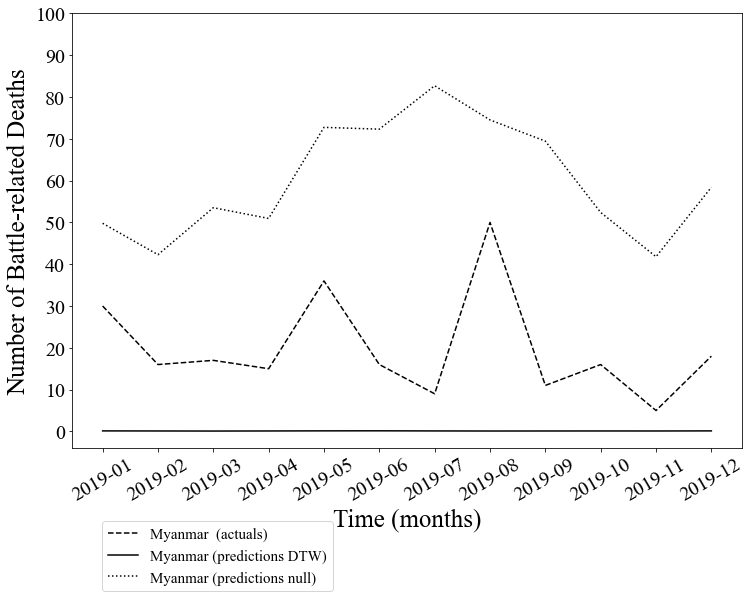

In [30]:
### Plot -------
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()

ax.plot(df["year_month"].loc[(df["country_x"]=="Myanmar (Burma)") &
                              (df["year"]==2019)], 
        df["best"].loc[(df["country_x"]=="Myanmar (Burma)") &
                              (df["year"]==2019)],
                              color = "black", 
                              linestyle = "dashed",
                              label = "Myanmar  (actuals)")

ax.plot(df["year_month"].loc[(df["country_x"]=="Myanmar (Burma)") &
                              (df["year"]==2019)], 
        df["best_preds"].loc[(df["country_x"]=="Myanmar (Burma)") &
                              (df["year"]==2019)],
                              color = "black", 
                              linestyle = "solid",
                              label = "Myanmar (predictions DTW)")

ax.plot(df["year_month"].loc[(df["country_x"]=="Myanmar (Burma)") &
                              (df["year"]==2019)], 
        df["best_preds_null"].loc[(df["country_x"]=="Myanmar (Burma)") &
                              (df["year"]==2019)],
                              color = "black", 
                              linestyle = "dotted",
                              label = "Myanmar (predictions null)")
# Labels
ax.set_ylabel('Number of Battle-related Deaths', 
                fontsize = 25, 
                fontname='Times New Roman')

ax.set_xlabel('Time (months)', 
                fontsize = 25, 
                fontname='Times New Roman')

# Ticks
ax.tick_params(axis='x', 
               labelsize=20)
plt.xticks(rotation = 30)
ax.set_yticks(np.arange(0, 
                       110, 
                       10))
ax.tick_params(axis='y', 
               labelsize=20)

for tick in ax.get_xticklabels():
    tick.set_fontname("Times New Roman")
for tick in ax.get_yticklabels():
    tick.set_fontname("Times New Roman")

ax.legend(bbox_to_anchor=(0.4, -0.15), 
          prop={'size': 15, 
                'family': 'Times New Roman'})

fig.savefig(os.path.join(out_paths["eval"], 
                         f"_preds_plot_01"), 
                         dpi=100,
                         bbox_inches="tight")

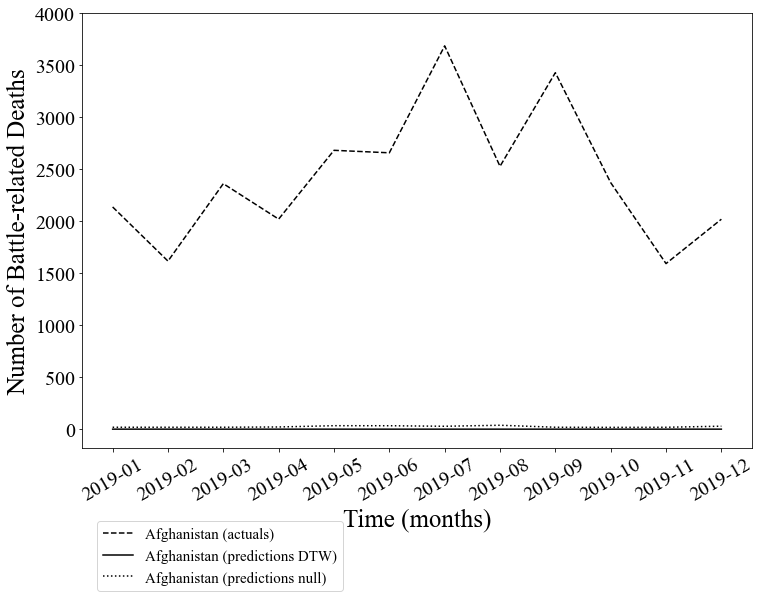

In [31]:
### Plot -------
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()

ax.plot(df["year_month"].loc[(df["country_x"]=="Afghanistan") &
                              (df["year"]==2019)], 
        df["best"].loc[(df["country_x"]=="Afghanistan") &
                              (df["year"]==2019)],
                              color = "black", 
                              linestyle = "dashed",
                              label = "Afghanistan (actuals)")

ax.plot(df["year_month"].loc[(df["country_x"]=="Afghanistan") &
                              (df["year"]==2019)], 
        df["best_preds"].loc[(df["country_x"]=="Afghanistan") &
                              (df["year"]==2019)],
                              color = "black", 
                              linestyle = "solid",
                              label = "Afghanistan (predictions DTW)")

ax.plot(df["year_month"].loc[(df["country_x"]=="Afghanistan") &
                              (df["year"]==2019)], 
        df["best_preds_null"].loc[(df["country_x"]=="Afghanistan") &
                              (df["year"]==2019)],
                              color = "black", 
                              linestyle = "dotted",
                              label = "Afghanistan (predictions null)")

# Labels
ax.set_ylabel('Number of Battle-related Deaths', 
                fontsize = 25, 
                fontname='Times New Roman')

ax.set_xlabel('Time (months)', 
                fontsize = 25, 
                fontname='Times New Roman')

# Ticks
ax.tick_params(axis='x', 
               labelsize=20)
plt.xticks(rotation = 30)
ax.set_yticks(np.arange(0, 
                       4500, 
                       500))
ax.tick_params(axis='y', 
               labelsize=20)

for tick in ax.get_xticklabels():
    tick.set_fontname("Times New Roman")
for tick in ax.get_yticklabels():
    tick.set_fontname("Times New Roman")

ax.legend(bbox_to_anchor=(0.4, -0.15), 
          prop={'size': 15, 
                'family': 'Times New Roman'})

fig.savefig(os.path.join(out_paths["eval"], 
                         f"_preds_plot_02"), 
                         dpi=100,
                         bbox_inches="tight")

In [20]:
### Remove inf predicitons -----
df_s = df.loc[df["best_preds"]<100000]

In [21]:
### Evaluations ------
# https://scikit-learn.org/stable/modules/model_evaluation.html
eval_score_null = pd.DataFrame(columns=['Model', 
                                   'R2', 
                                   'MAE', 
                                   'MSE'])

eval_score_dtw = pd.DataFrame(columns=['Model', 
                                   'R2', 
                                   'MAE', 
                                   'MSE'])

r2_null = r2_score(df_s["best"], df_s["best_preds_null"])
r2_dtw = r2_score(df_s["best"], df_s["best_preds"])

mae_null = mean_absolute_error(df_s["best"], df_s["best_preds_null"])
mae_dtw = mean_absolute_error(df_s["best"], df_s["best_preds"])

mse_null = mean_squared_error(df_s["best"], df_s["best_preds_null"])
mse_dtw = mean_squared_error(df_s["best"], df_s["best_preds"])

eval_score_null = eval_score_null.append({'Model': "Null", 
                                'R2': r2_null, 
                                'MAE': mae_null, 
                                'MSE': mse_null}, 
                                ignore_index=True)

eval_score_dtw = eval_score_dtw.append({'Model': "DTW", 
                                'R2': r2_dtw, 
                                'MAE': mae_dtw, 
                                'MSE': mse_dtw}, 
                                ignore_index=True)


pd.options.display.float_format = '{:.5f}'.format
tab = pd.concat([eval_score_null, eval_score_dtw])
tab = tab.round(decimals=5)

# Save table
tab.to_latex(os.path.join(out_paths["eval"], 
                            f"_eval_tab.tex"), index=False)


tab

,Model,R2,MAE,MSE
0,Null,-0.01548,70.06010,66195.43449
0,DTW,-0.02629,41.46889,66900.26547


In [22]:
### Save dataset with predictions -----------
df.to_csv(os.path.join(out_paths["data"], 
                            "ucdp_preds.csv"), 
                             index=True, 
                             sep=',')
df

,year_month,country_id,best,high,low,year,country_x,"Afghanistan, 1989","Afghanistan, 1990","Afghanistan, 1991",...,"Yemen (North Yemen), 2012","Yemen (North Yemen), 2013","Yemen (North Yemen), 2014","Yemen (North Yemen), 2015","Yemen (North Yemen), 2016","Yemen (North Yemen), 2017","Yemen (North Yemen), 2018","Yemen (North Yemen), 2019",best_preds,best_preds_null
0,1989-01,700,691,1122,684,1989,Afghanistan,0.00000,1345.97474,1643.62709,...,1426.83776,1937.18120,1659.27816,1379.08992,1484.98754,1414.72365,1184.62821,1688.52598,0.00959,48.19403
1,1989-02,700,160,160,41,1989,Afghanistan,0.00000,1345.97474,1643.62709,...,1426.83776,1937.18120,1659.27816,1379.08992,1484.98754,1414.72365,1184.62821,1688.52598,0.01956,142.82090
2,1989-03,700,1744,6045,516,1989,Afghanistan,0.00000,1345.97474,1643.62709,...,1426.83776,1937.18120,1659.27816,1379.08992,1484.98754,1414.72365,1184.62821,1688.52598,0.00836,18.14925
3,1989-04,700,494,1359,63,1989,Afghanistan,0.00000,1345.97474,1643.62709,...,1426.83776,1937.18120,1659.27816,1379.08992,1484.98754,1414.72365,1184.62821,1688.52598,0.01505,28.16418
4,1989-05,700,436,1705,0,1989,Afghanistan,0.00000,1345.97474,1643.62709,...,1426.83776,1937.18120,1659.27816,1379.08992,1484.98754,1414.72365,1184.62821,1688.52598,0.01419,24.83582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2019-08,678,283,291,283,2019,Yemen (North Yemen),1688.52598,451.44989,234.54850,...,488.76170,351.30186,248.20757,1515.85751,359.38280,811.83557,806.03536,0.00000,0.03497,71.04478
8,2019-09,678,180,185,172,2019,Yemen (North Yemen),1688.52598,451.44989,234.54850,...,488.76170,351.30186,248.20757,1515.85751,359.38280,811.83557,806.03536,0.00000,0.02361,66.92537
9,2019-10,678,128,128,128,2019,Yemen (North Yemen),1688.52598,451.44989,234.54850,...,488.76170,351.30186,248.20757,1515.85751,359.38280,811.83557,806.03536,0.00000,0.03500,50.71642
10,2019-11,678,90,99,88,2019,Yemen (North Yemen),1688.52598,451.44989,234.54850,...,488.76170,351.30186,248.20757,1515.85751,359.38280,811.83557,806.03536,0.00000,0.03619,40.52239
